# LSTM based Progressive Rock and Others genres music classification

Single song is split into multiple pieces of consecutive 200 time samples corresponding to top 13 mfcc feature. Number of pieces of songs is dependent on hop_length and sampling frequency. The label for each genrated piece is same as the original song. Song is assigned label corresponding to maximum occuring label on each piece.

## Importing Libraries.

In [0]:
# feature extractoring and preprocessing data
import librosa
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix
from keras.layers.advanced_activations import ELU
#Keras
import keras

import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## User Parameters
  
**pathToFeatures**: Folder location where all the songs are present  
**X_TrainFeatureName**: File name for the generated Input features for training from 1st two folders  
**Y_TrainFeatureName**: File name for the Labels corresponding to inputs for training  from 1st two folders  
**X_ContinuedFeatureName**: File name for the generated Input features for training from rest two folders    
**Y_ContinuedFeatureName**: File name for the Labels corresponding to inputs  for rest two folders  
**X_ValidationFeatureName**:  File name for the generated Input features from validation set  
**Y_ValidationFeatureName**:  File name for the Labels corresponding to input features from validation set  
**X_TestFeatureName**:  File name for the generated Input features from test set  
**Y_TestFeatureName**:   File name for the Labels corresponding to input features from test set  
**modelName**:  File name to save the trained model


In [0]:
pathToFeatures = '/content/gdrive/My Drive/My test/'
X_TrainFeatureName = 'X_LSTM_Train.npy'
Y_TrainFeatureName = 'Y_LSTM_Train.npy'
X_ContinuedFeatureName = 'X_LSTM_Train_continued.npy'
Y_ContinuedFeatureName = 'Y_LSTM_Train_continued.npy'
X_ValidationFeatureName = 'X_LSTM_Validation.npy'
Y_ValidationFeatureName = 'Y_LSTM_Validation.npy'
X_TestFeatureName = 'X_LSTM_Test.npy'
Y_TestFeatureName = 'Y_LSTM_Test.npy'
modelName = 'LSTM_Model_100.h5'

##Load Training Features

In [0]:
X = np.load(pathToFeatures + X_TrainFeatureName)
Y = np.load(pathToFeatures + Y_TrainFeatureName)
X_cont = np.load(pathToFeatures + X_ContinuedFeatureName)
Y_cont = np.load(pathToFeatures + Y_ContinuedFeatureName)
X = np.concatenate((X, X_cont), axis=0)
Y = np.concatenate((Y, Y_cont), axis=0)
print(X.shape, Y.shape)
X_train = X
y_train = Y

(13337, 200, 13) (13337, 1)


##Train LSTM based Model for classification.

Compiling ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 200, 128)          72704     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 113,985
Trainable params: 113,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13337/13337 [==============================] - 207s 16ms/step - loss: 0.6219 - acc: 0.6590
Epoch 2/100
13337/13337 [==============================] - 201s 15ms/step - loss: 0.5831 - acc: 0.6885
Epoch 3/100
13337/13337 [==============================] - 201s 15ms/step - loss: 0.5713 - acc: 0.6999
Epoch 4/100
13337/13337 [==============================] - 200s 15ms/step - l

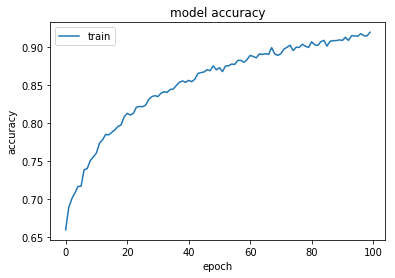

In [0]:
model = models.Sequential()

model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Bidirectional(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False)))
model.add(layers.Dense(units=1, activation='sigmoid'))


print("Compiling ...")
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train,y_train, epochs = 100, batch_size=64)

model.save(pathToFeatures + modelName)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Run model on Validation set

In [0]:
X_val = np.load(pathToFeatures + X_ValidationFeatureName, allow_pickle=True)
y_val = np.load(pathToFeatures + Y_ValidationFeatureName, allow_pickle=True)
print(X_val.shape,y_val.shape)
y_val_fixed = []
labelIndex = 0
for i in range(0,X_val.shape[0]):  
  y_val_fixed.append(y_val[labelIndex])
  labelIndex += np.asarray(X_val[i]).shape[0]
  X_val[i] = np.asarray(X_val[i])
y_val_fixed = np.asarray(y_val_fixed)
print(y_val_fixed.shape)
print(np.array(X_val).shape)

(92,) (4187, 1)
(92, 1)
(92,)


In [0]:
model = load_model(pathToFeatures + modelName)

print(X_val.shape[0], y_val.shape)
predictionList = []
actualList = []
for i in range(0,X_val.shape[0]):
  predictions = model.predict(np.asarray(X_val[i]))
  y_pred = []
  for j in range(predictions.shape[0]):
    if(predictions[j] > 0.5):
      out = 1
    else:
      out = 0
    y_pred.append(out)
  
  count = np.count_nonzero(y_pred)
  if(count >= len(y_pred)*0.45):
    predictionList.append(1)
  else:
    predictionList.append(0)  
  print(int((count/len(y_pred))*100),count, len(y_pred), y_val_fixed[i][0], predictionList[i])
confusion_matrix(y_val_fixed,np.asarray(predictionList))
        


92 (4187, 1)
21 7 33 0 0
70 22 31 0 1
16 4 24 0 0
13 4 29 0 0
58 23 39 0 1
35 11 31 0 0
52 23 44 0 1
43 10 23 0 0
88 22 25 0 1
36 11 30 0 0
34 11 32 0 0
77 17 22 0 1
13 10 73 0 0
8 3 34 0 0
17 4 23 0 0
10 4 39 0 0
44 8 18 0 0
9 3 31 0 0
26 14 53 0 0
32 8 25 0 0
37 16 43 0 0
43 10 23 0 0
23 9 38 0 0
20 5 24 0 0
0 0 20 0 0
31 7 22 0 0
29 8 27 0 0
6 2 30 0 0
12 4 33 0 0
69 29 42 0 1
33 19 56 0 0
37 6 16 0 0
28 6 21 0 0
10 3 30 0 0
41 10 24 0 0
92 13 14 0 1
18 7 38 0 0
0 0 22 0 0
22 9 40 0 0
93 31 33 0 1
0 0 25 0 0
10 3 30 0 0
19 9 46 0 0
57 34 59 0 1
48 18 37 0 1
29 16 55 0 0
37 6 16 0 0
15 4 26 0 0
30 6 20 0 0
16 3 18 0 0
42 17 40 0 0
60 15 25 0 1
2 1 36 0 0
58 17 29 0 1
20 6 29 0 0
0 0 22 0 0
0 0 21 0 0
57 12 21 0 1
15 4 26 0 0
24 11 45 0 0
70 21 30 0 1
15 3 20 0 0
75 12 16 0 1
31 9 29 0 0
27 5 18 0 0
63 21 33 0 1
0 0 16 0 0
48 14 29 0 1
4 2 44 0 0
8 1 12 0 0
3 1 26 0 0
77 108 140 1 1
48 68 141 1 1
77 67 87 1 1
62 30 48 1 1
65 98 149 1 1
64 76 117 1 1
89 60 67 1 1
87 43 49 1 1
54 67 123

array([[54, 17],
       [ 3, 18]])

##Run Model on Test Set

In [0]:
X_test = np.load(pathToFeatures + X_TestFeatureName, allow_pickle=True)
y_test = np.load(pathToFeatures + Y_TestFeatureName)
print(X_test.shape,y_test.shape)
y_test_fixed = []
labelIndex = 0
for i in range(0,X_test.shape[0]):  
  y_test_fixed.append(y_test[labelIndex])
  labelIndex += np.asarray(X_test[i]).shape[0]
  X_test[i] = np.asarray(X_test[i])
y_test_fixed = np.asarray(y_test_fixed)
print(y_test_fixed.shape)
print(np.array(X_test).shape)

(200,) (10225, 1)
(200, 1)
(200,)


In [0]:
model = load_model(pathToFeatures + modelName)

print(X_test.shape[0], y_test.shape)
predictionList = []
actualList = []
for i in range(0,X_test.shape[0]):
  predictions = model.predict(np.asarray(X_test[i]))
  y_pred = []
  for j in range(predictions.shape[0]):
    if(predictions[j] > 0.5):
      out = 1
    else:
      out = 0
    y_pred.append(out)
  
  count = np.count_nonzero(y_pred)
  if(count >= len(y_pred)*0.45):
    predictionList.append(1)
  else:
    predictionList.append(0)  
  print(int((count/len(y_pred))*100),count, len(y_pred), y_test_fixed[i][0], predictionList[i])
confusion_matrix(y_test_fixed,np.asarray(predictionList))
        


200 (10225, 1)
48 13 27 1 1
62 83 132 1 1
58 21 36 1 1
82 33 40 1 1
19 6 31 1 0
66 8 12 1 1
57 23 40 1 1
93 41 44 1 1
26 6 23 1 0
51 32 62 1 1
20 6 29 1 0
50 33 65 1 1
70 24 34 1 1
75 28 37 1 1
54 20 37 1 1
34 34 100 1 0
49 38 77 1 1
56 41 72 1 1
56 22 39 1 1
32 21 64 1 0
49 35 71 1 1
80 17 21 1 1
44 26 58 1 0
27 17 62 1 0
51 19 37 1 1
56 84 149 1 1
47 29 61 1 1
68 42 61 1 1
20 6 30 1 0
16 20 119 1 0
59 22 37 1 1
53 17 32 1 1
34 66 193 1 0
63 30 47 1 1
48 19 39 1 1
49 35 71 1 1
35 40 112 1 0
52 38 73 1 1
61 40 65 1 1
45 41 90 1 1
48 40 82 1 1
27 30 111 1 0
78 86 109 1 1
54 86 158 1 1
72 58 80 1 1
26 11 41 1 0
43 32 73 1 0
64 97 151 1 1
76 20 26 1 1
10 4 38 1 0
72 53 73 1 1
44 11 25 1 0
37 64 171 1 0
50 24 48 1 1
45 22 48 1 1
30 19 63 1 0
30 24 80 1 0
60 49 81 1 1
53 22 41 1 1
58 39 67 1 1
80 40 50 1 1
62 28 45 1 1
64 25 39 1 1
61 63 103 1 1
38 16 42 1 0
60 21 35 1 1
41 24 58 1 0
56 21 37 1 1
36 25 68 1 0
61 89 145 1 1
57 45 78 1 1
53 40 75 1 1
16 4 25 1 0
52 39 74 1 1
70 42 60 1 1
78 5

array([[88, 12],
       [35, 65]])